# 설정

In [2]:
# 파이썬 ≥ 3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥ 0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 회귀 실습 - 자전거 대여 수요 예측

해당 데이터 세트에는 2011년 1월부터 2012년 12월까지 날짜/시간, 기온, 습도, 풍속 등의 정보를 기반으로 1시간 간격 동안의 자전거 대여 횟수가 기재돼 있다. 데이터 세트의 주요 칼럼은 다음과 같다. 이 중 결정 값은 맨 마지막 칼럼인 count로 '대여 횟수'를 의미한다.

<ul>
    <li><b>datetime</b>: hourly date + timestamp</li>
    <li><b>season</b>: 1=봄, 2=여름, 3=가을, 4=겨울</li>
    <li><b>holiday</b>: 1=토, 일요일의 주말을 제외한 국경일 등의 휴일, 0=휴일이 아닌 날</li>
    <li><b>workingday</b>: 1=토, 일요일의 주말 및 휴일이 아닌 주중, 0=주말 및 휴일</li>
    <li><b>weather</b>:<ol>
            <li>맑음, 약간 구름 낀 흐림</li>
            <li>안개, 안개 + 흐림</li>
            <li>가벼운 눈, 가벼운 비 + 천둥</li>
            <li>심한 눈/비, 천둥/번개</li>
        </ol>
    </li>
    <li><b>temp</b>: 온도(섭씨)</li>
    <li><b>atemp</b>: 체감온도(섭씨)</li>
    <li><b>humidity</b>: 상대습도</li>
    <li><b>windspeed</b>: 풍속</li>
    <li><b>casual</b>: 사전에 등록되지 않는 사용자가 대여한 횟수</li>
    <li><b>registered</b>: 사전에 등록된 사용자가 대여한 횟수</li>
    <li><b>count</b>: 대여 횟수</li>
</ul>

## 데이터 클렌징 및 가공

train.csv 데이터 세트를 이용해 모델을 학습한 후 대여 횟수(count)를 예측해 보겠다. 데이터 세트를 DataFrame으로 로드해 대략적으로 데이터를 확인해 보겠다.

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

bike_df = pd.read_csv('./bike-sharing-demand/train.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


해당 데이터 세트는 10886개의 레코드와 12개의 칼럼으로 구성돼 있다. 데이터 칼럼의 타입을 살펴보겠다.

In [6]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


10886개의 로우 데이터 중 Null 데이터는 없으며, 대부분의 칼럼이 int 또는 float 숫자형인데, datetime 칼럼만 object 형이다. Datetime 칼럼의 경우 년-월-일 시:분:초 문자 형식으로 돼 있으므로 이에 대한 가공이 필요하다. datetime을 년, 월, 일, 그리고 시간과 같이 4개의 속성으로 분리하겠다. 판다스에서는 datetime과 같은 형태의 문자열을 년도, 월, 일, 시간, 분, 초로 편리하게 변환하려면 먼저 문자열을 'datetime' 타입으로 변경해야 한다. 판다스는 문자열을 datetime 타입으로 변환하는 <code>apply(pd.to_datetime)</code> 메서드를 제공한다. 이를 이용해 년, 월, 일, 시간 칼럼을 추출하겠다.

In [8]:
# 문자열을 datetime 타입으로 변경.
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x: x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x: x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x: x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


새롭게 year, month, day, hour 칼럼이 추가됐다. 이제 datetime 칼럼은 삭제하겠다. 또한 casual 칼럼은 사전에 등록하지 않은 사용자의 자전거 대여 횟수이고, registered는 사전에 등록한 사용자의 대여 횟수이며, casual + registered = count 이므로 casual과 registered가 따로 필요하지는 않다. 오히려 상관도가 높아 예측을 저해할 우려가 있으므로 이 두 칼럼도 삭제하겠다.

In [9]:
drop_columns = ['datetime', 'casual', 'registered']
bike_df.drop(drop_columns, axis=1, inplace=True)

다음으로 다양한 회귀 모델을 데이터 세트에 적용해 예측 성능을 측정해 보겠다. 캐글에서 요구한 성능 평가 방법은 RMSLE<sup>Root Mean Squared Log Error</sup>이다. 즉, 오류 값의 로그에 대한 RMSE다. 아쉽게도 사이킷런은 RMSLE를 제공하지 않아서 RMSLE를 수행하는 성능 평가 함수를 직접 만들어 보겠다. RMSLE뿐만 아니라 MSE, RMSE까지 한꺼번에 평가하는 함수도 만들겠다.

$$
\text{RMSLE} = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i + 1) - log(\hat{y}_i + 1))^2}
$$

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_squared_error()를 이용해 RMSE 계산
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

# MSE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    # MAE는 사이킷런의 mean_absolute_error()로 계산
    mae_val = mean_absolute_error(y, pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

위의 <code>rmsle()</code> 함수를 만들 때 한 가지 주의해야 할 점이 있다. rmsle를 구할 때 넘파이의 <code>log()</code>함수를 이용하거나 사이킷런의 <code>mean_squared_log_error()</code>를 이용할 수도 있지만 데이터 값의 크기에 따라 오버플로/언더플로(overflow/underflow) 오류가 발생하기 쉽다. 예를 들어 <code>rmsle()</code>를 다음과 같이 정의했을 때 쉽게 오류가 발생할 수 있다.

In [ ]:
# 다음과 같은 rmsle 구현은 오버플로나 언더플로 오류를 발생하기 쉽다
from sklearn.metrics import mean_squared_log_error

def rmsle(y, pred):
    msle = mean_squared_log_error(y, pred)
    rmsle = np.sqrt(mse)
    return rmsle

따라서 <code>log()</code>보다는 <code>log1p()</code>를 이용하는데, <code>log1p()</code>의 경우는 1 + <code>log()</code>값으로 log 변환값에 1을 더하므로 이런 문제를 해결해 준다. 그리고 <code>log1p()</code>로 변환된 값은 다시 넘파이의 <code>expml()</code> 함수로 쉽게 원래의 스케일로 복원될 수 있다.

## 로그 변환, 피처 인코딩과 모델 학습/예측/평가

이제 회귀 모델을 이용해 자전거 대여 횟수를 예측해 보겠다. 회귀 모델을 적용하기 전에 데이터 세트에 대해서 먼저 처리해야 할 사항이 있다. 결괏값이 정규 분포로 돼 있는지 확인하는 것과 카테고리형 회귀 모델의 경우 원-핫 인코딩으로 피처를 인코딩하는 것이다. 회귀 모델을 적용하면서 이 두 가지 사항을 확인해 보겠다.

먼저 사이킷런의 LinearRegression 객체를 이용해 회귀 예측을 하겠다.

In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3,
                                                    random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


RMSLE: 1.165, RMSE: 140.900, MAE: 105.924는 실제 Target 데이터 값인 대여 횟수(Count)를 감안하면 예측 오류로서는 비교적 큰 값이다. 실제 값과 예측값이 어느 정도 차이가 나는지 DataFrame의 칼럼으로 만들어서 오류 값이 가장 큰 순으로 5개만 확인해 보겠다.

In [13]:
def get_top_error_data(y_test, pred, n_tops=5):
    # DataFrame의 칼럼으로 실제 대여 횟수(count)와 예측값을 서로 비교할 수 있도록 생성.
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    
# 예측값과 실제 값이 가장 큰 데이터 순으로 출력.
    print(result_df.sort_values(by='diff', ascending=False)[:n_tops])
    
get_top_error_data(y_test, pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


가장 큰 상위 5위 오류 값은 546~568로 실제 값을 감안하면 예측 오류가 꽤 크다. 회귀에서 이렇게 큰 예측 오류가 발생할 경우 가장 먼저 살펴볼 것은 Target 값의 분포가 왜곡된 형태를 이루고 있는지 확인하는 것이다. Target 값의 분포는 정규 분포 형태가 가장 좋다. 그렇지 않고 왜곡된 경우에는 회귀 예측 성능이 저하되는 경우가 발생하기 쉽다. 판다스 DataFrame의 <code>hist()</code>를 이용해 자전거 대여 모델의 Target 값인 count 칼럼이 정규 분포를 이루는지 확인해 보겠다.

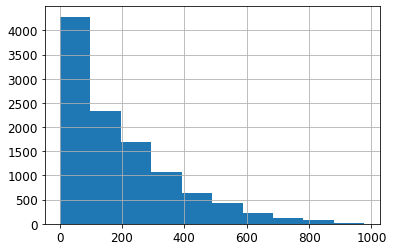

In [16]:
y_target.hist();

count 칼럼 값이 정규 분포가 아닌 0~200 사이에 왜곡돼 있는 것을 알 수 있다. 이렇게 왜곡된 값을 정규 분포 형태로 바꾸는 가장 일반적인 방법은 로그를 적용해 변환하는 것이다. 여기서는 넘파이의 <code>log1p()</code>를 이용하겠다. 이렇게 변경된 Target 값을 기반으로 학습하고 예측한 값은 다시 <code>expm1()</code> 함수를 적용해 원래 scale 값으로 원상 복구하면 된다. <code>log1p()</code>를 적용한 'count' 값의 분포를 확인하겠다.

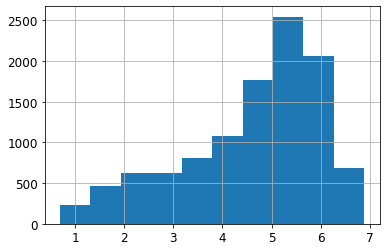

In [17]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist();

로그로 Target 값을 변환한 후에 원하는 정규 분포 형태는 아니지만 변환하기 전보다는 왜곡 정도가 많이 향상됐다. 이를 이용해 다시 학습한 후 평가를 수행해 보겠다.

In [18]:
# 타깃 칼럼인 count 값을 log1p로 로그 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영해 학습/테스트 데이터 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3,
                                                    random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 세트의 Target 값은 로그 변환됐으므로 다시 expm1을 이용해 원래 스케일로 변환
y_test_exp = np.expm1(y_test)

# 예측값 역시 로그 변환된 타깃 기반으로 학습돼 예측됐으므로 다시 expm1로 스케일 변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


RMSLE 오류는 줄어들었지만, RMSE는 오히려 더 늘어났다. 이에 대한 이유를 알아보기 위해 각 피처의 회귀 계수 값을 시각화해 보겠다.

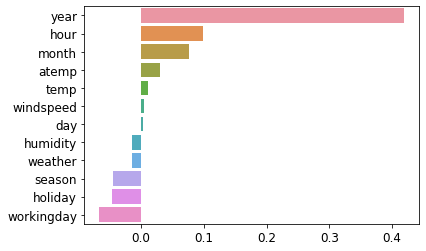

In [23]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index);

Year 피처의 회귀 계수 값이 독보적으로 큰 값을 가지고 있다. year는 2011년, 2012년 두 개의 값으로 돼 있다. year에 따라서 자전거 대여 횟수가 크게 영향을 받는다는 것은 납득하기 어렵다. 여름, 가을과 같이 자전거를 타기 좋은 계절이나 낮 시간대 등의 다양한 요소를 제외하고 year의 회귀 계수가 이렇게 큰 이유는 무엇일까? year 피처는 연도를 뜻하므로 카테고리<sup>Category</sup>형 피처지만, 숫자형 값으로 돼 있다. 더군다나 아주 큰 값인 2011, 2012로 돼 있다. 사이킷런은 카테고리만을 위한 데이터 타입이 없으며, 모두 숫자로 변환해야 한다. 하지만 이처럼 숫자형 카테고리 값을 선형 회귀에 적용할 경우 회귀 계수를 연산할 때 이 숫자형 값에 크게 영향을 받는 경우가 발생할 수 있다. 따라서 선형 회귀에서는 이러한 피처 인코딩에 원-핫 인코딩을 적용해 변환해야 한다.

판다스의 <code>get_dummies()</code>를 이용해 이러한 year 칼럼을 비롯해 month, day, hour, holiday, workingday, season, weather 칼럼도 모두 원-핫 인코딩한 후에 다시 에측 성능을 확인해 보겠다.

In [24]:
# 'year', 'month', 'day', 'hour' 등의 피처를 One-Hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month', 'day', 'hour', 'holiday',
                                                     'workingday', 'season', 'weather'])

사이킷런의 선형 회귀 모델인 LinearRegression, Ridge, Lasso 모두 학습해 예측 성능을 확인한다. 이를 위해 모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환하는 <code>get_model_predict()</code> 함수를 만들겠다.

In [37]:
# 원-팟 인코딩이 적용된 피처 데이터 세트 기반으로 학습/예측 데이터 분할.
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,
                                                    test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
# end of function get_model_predict

# 모델별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


원-핫 인코딩을 적용하고 나서 선형 회귀의 예측 성능이 많이 향상됐다. 원-핫 인코딩된 데이터세트에서 회귀 계수가 높은 피처를 다시 시각화하겠다. 원-핫 인코딩으로 피처가 늘어났으므로 회귀 계수 상위 20개 피처를 추출해 보겠다.

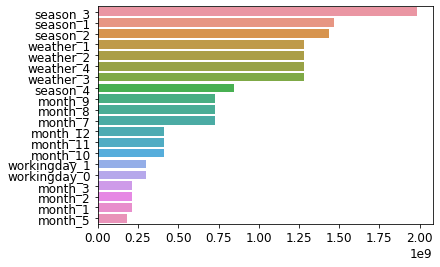

In [45]:
coef = pd.Series(np.abs(lr_reg.coef_), index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index);

선형 회귀 모델 시 season의 계절 관련 피처들과 weather 계절 관련 피처들, 그리고 month 월 관련 피처들의 회귀 계수가 높은 것을 알 수 있다. 계절, 날씨, 월 그리고 주말/주중 등 상식선에서 자전거를 타는 데 필요한 피처의 회귀 계수가 높아졌다. 이처럼 선형 회귀 수행 시에는 피처를 어떻게 인코딩하는가가 성능에 큰 영향을 미칠 수 있다.

이번에는 회귀 트리를 이용해 회귀 예측을 수행하겠다. 앞에서 적용한 Target 값의 로그 변환된 값과 원-핫 인코딩된 피처 데이터 세트를 그대로 이용해 랜덤 포레스트, GBM, XGBoost, LightGBM을 순차적으로 성능 평가해 보겠다. XGBoost의 경우 DataFrame이 학습/테스트 데이터로 입력될 경우 버전에 따라 오류가 발생할 수 있으므로 학습/테스트 데이터를 DataFrame의 values 속성을 이용해 넘파이 ndarray로 변환하겠다.

In [48]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM model별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    # XGBoost의 경우 DataFrame이 입력될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
    get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values,
                      is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.354, RMSE: 50.356, MAE: 31.175
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.329, MAE: 32.743
### XGBRegressor ###
RMSLE: 0.342, RMSE: 51.732, MAE: 31.251
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029


앞의 선형 회귀 모델보다 회귀 예측 성능이 개선됐다. 하지만 이것이 회귀 트리가 선형 회귀보다 더 나은 성능을 가진다는 의미는 아니다. 데이터 세트의 유형에 따라 결과는 얼마든지 달라질 수 있다.